In [136]:
import geopandas as gpd
import pandas as pd
import os
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from shapely.geometry import Point
from pyproj import Transformer

In [8]:
config_path = '/home/benchuser/code/config.yml'
with open(config_path, "r") as file:
    config = yaml.safe_load(file)
        
version = config['dataset']['version']
# version = 'v0.40.2'
working_dir = Path(config['working_dir'])
output_dir = Path(config['output_dir'])
metadata = config['metadata']['file']

print(yaml.dump(config))

aoi:
  version: v0.30
chips:
  chip_size: 960
  sample_size: 960
dataset:
  version: v0.40.3
dem:
  collection: cop-dem-glo-30
  native_crs: false
  resolution: 30
  year: 2021-01-02/2021-12-31
excluded_aoi_indices:
- 12
- 25
- 46
- 60
- 81
- 153
land_cover:
  collection: io-lulc-annual-v02
  native_crs: false
  resolution: 10
  sampling_factor: null
  year: 2023-01-02/2023-12-31
landsat:
  bands:
  - coastal
  - blue
  - green
  - red
  - nir08
  - swir16
  - swir22
  - qa_pixel
  cloud_band: qa_pixel
  cloud_cover: 50
  collection: landsat-c2-l2
  native_crs: false
  platforms:
  - landsat-8
  - landsat-9
  resolution: 30
log_errors: true
metadata:
  file: metadata_df.csv
output_dir: /home/benchuser/final_data
sentinel_1:
  bands:
  - vv
  - vh
  collection: sentinel-1-rtc
  native_crs: false
  nodata_pixel_percentage: 5
  resolution: 10
sentinel_2:
  bands:
  - B01
  - B02
  - B03
  - B04
  - B05
  - B06
  - B07
  - B08
  - B8A
  - B09
  - B11
  - B12
  - SCL
  cloud_band: SCL
  clo

In [11]:
metadata_filepath = Path(config['working_dir']) / config['dataset']['version'] / config['metadata']['file']

In [12]:
metadata_df = pd.read_csv(metadata_filepath)

In [72]:
aoi_gdf = gpd.read_file(Path(config['working_dir']) / config['dataset']['version'] / f'{config['aoi']['version']}.geojson')
aoi_gdf['centroid'] = aoi_gdf.centroid
aoi_gdf.geometry = aoi_gdf['centroid']
aoi_gdf['error'] = aoi_gdf['error'].fillna('success')
aoi_gdf.loc[aoi_gdf['error'].str.len() > 50, 'error'] = 'unknown_error'

/tmp/ipykernel_292832/4028530158.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  aoi_gdf['centroid'] = aoi_gdf.centroid


In [93]:
aoi_gdf['error'].value_counts()

error
landsat_scenes_missing    156
success                   126
s2_scenes_missing          55
s1_scenes_missing          35
unknown_error              26
dem_scenes_missing          3
s1_stack_failure            2
lc_stack_failure            2
landsat_stack_failure       1
Name: count, dtype: int64

In [131]:
colors = {
    "dem_scenes_missing": "grey",
    "landsat_scenes_missing": "purple",
    "landsat_stack_failure": "pink",
    "lc_stack_failure": "yellow",
    "s1_scenes_missing": "blue",
    "s1_stack_failure": "lightblue",
    "s2_scenes_missing": "cyan",
    "success": "green",
    "uncategorized_error": "magenta"
    
}
cmap = ListedColormap(colors.values())


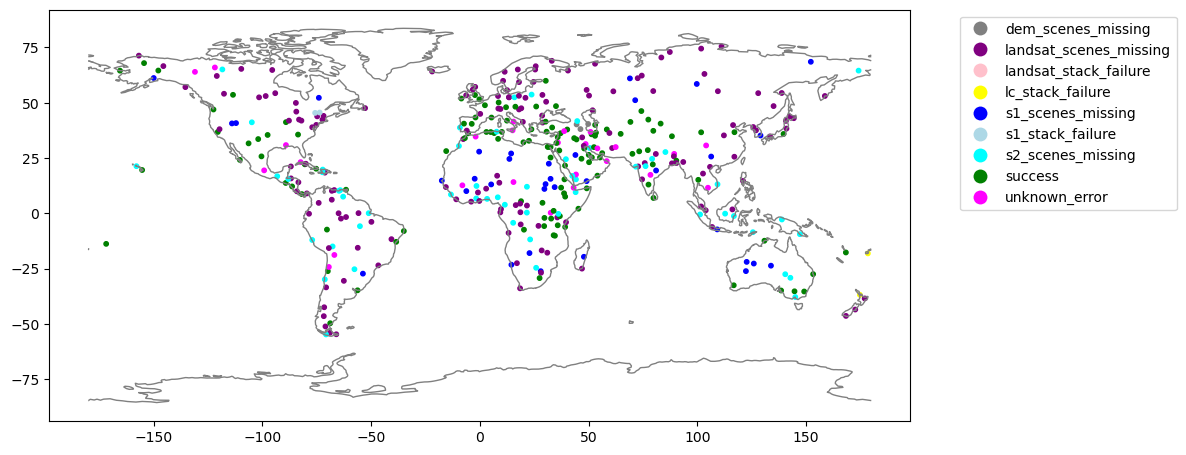

In [132]:
fig, ax = plt.subplots(figsize=(12, 8))
coastline = gpd.read_file('https://raw.githubusercontent.com/martynafford/natural-earth-geojson/refs/heads/master/110m/physical/ne_110m_coastline.json')
coastline.plot(color='grey', linewidth = 1, ax=ax)
aoi_gdf.plot('error', cmap=cmap, ax=ax, markersize=10, legend=True, legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left'})
plt.tight_layout()

# Show the plot
plt.show()

In [129]:
aoi_gdf['success'] = np.where(aoi_gdf['error'] == 'success', 'success', 'failure')
booleancmap = ListedColormap(['red', 'green'])

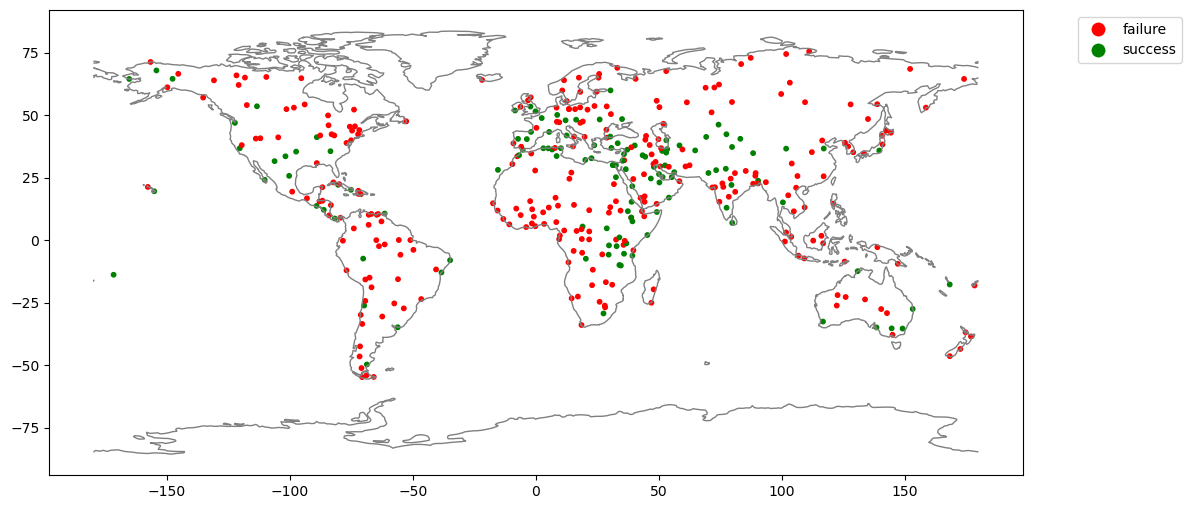

In [130]:
fig, ax = plt.subplots(figsize=(12, 8))
coastline = gpd.read_file('https://raw.githubusercontent.com/martynafford/natural-earth-geojson/refs/heads/master/110m/physical/ne_110m_coastline.json')
coastline.plot(color='grey', linewidth = 1, ax=ax)
aoi_gdf.plot('success', ax=ax, cmap = booleancmap, markersize=10, legend=True, legend_kwds={'bbox_to_anchor': (1.05, 1), 'loc': 'upper left'})
plt.tight_layout()

# Show the plot
plt.show()

<Axes: xlabel='error'>

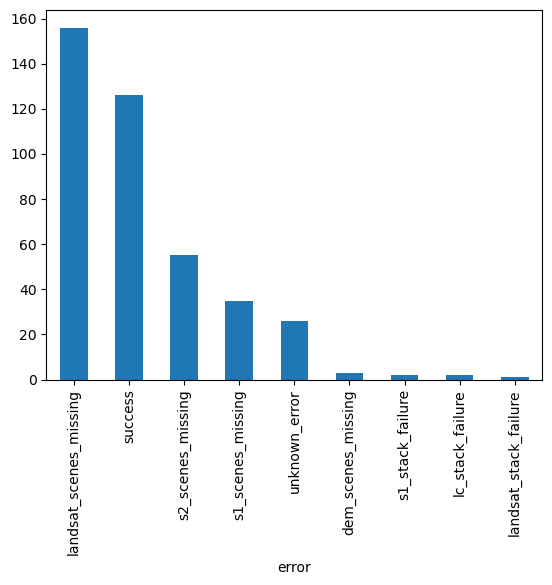

In [74]:
aoi_gdf['error'].value_counts().plot.bar()

In [194]:
len(aoi_gdf[aoi_gdf['error'] == 'success']) / len(aoi_gdf)

0.3103448275862069

In [87]:
pd.crosstab(df['lc'], df['error_msg'], margins=True)

error_msg,dem_values_missing,landsat_values_missing,s1_values_missing,s2_values_missing,success,All
lc,,,,,,
1,4747,7207,12908,305,1466,26633
2,2,8735,9405,186,1342,19670
5,0,2950,4639,105,3383,11077
7,0,175,735,0,363,1273
8,13,1387,12391,5,6913,20709
11,0,5184,22472,104,10998,38758
All,4762,25638,62550,705,24465,118120


In [139]:
def get_centroid_4326(row):
    transformer = Transformer.from_crs(f"EPSG:{row['epsg']}", "EPSG:4326", always_xy=True)
    lon, lat = transformer.transform(row['x_center'], row['y_center'])
    return Point(lon, lat)

In [ ]:
metadata_df['centroid_4326'] = metadata_df.apply(get_centroid_4326, axis=1)
metadata_gdf = gpd.GeoDataFrame(metadata_df, geometry = 'centroid_4326', crs=4326)
metadata_gdf['lc and error'] = metadata_gdf['lc'].astype(str) + '_' + metadata_df['error_msg']

In [192]:
metadata_gdf[metadata_gdf['aoi_index'] == 51].explore('lc and error', tiles="CartoDB positron", marker_kwds=dict(radius=5))

In [184]:
metadata_gdf[metadata_gdf['lc'] == 7].explore('lc', tiles="CartoDB positron", marker_kwds=dict(radius=10))

In [191]:

metadata_gdf[metadata_gdf['aoi_index'] == 122].explore('lc and error', tiles="CartoDB positron", marker_kwds=dict(radius=4))